In [1]:

"""
Implementation of Linear Spectral Unmixing Analysis (LSMA) for fractional roof material type

"""

%matplotlib inline

# Install required packages 
!pip install pysptools
!pip install multiprocess
!pip install cvxopt

import os, sys
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import earthpy.plot as ep
import pysptools.util as sp_utils
import pysptools.noise as noise
import pysptools.abundance_maps as amap
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocess as mp
import cvxopt
import random
from osgeo import gdal
from osgeo import osr
from osgeo import gdal_array
from functools import partial
from functools import reduce

print(os.getcwd())

# Coordinate Ref. System
proj = 32618  # UTM Zone 18N

print("Completed ...")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 23.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pysptools: filename=pysptools-0.15.0-py3-none-any.whl size=8133732 sha256=103d272e0ca0484401cdb0cba803955fbbd9cced4959a8568828694eb030f151
  Stored in directory: /home/jovyan/.cache/pip/wheels/ea/08/3b/c045ea3722a5fef1f8698f060a17b59140235fef580fe4f1b5
Successfully built pysptools
  Obtaining dependency information for multiprocess from https://files.pythonhosted.org/packages/35/a8/36d8d7b3e46b377800d8dec47891cdf05842d1a2366909ae4a0c89fbc5e6/multiprocess-0.70.15-py310-none-any.whl.metadata
  Obtaining dependency information for dill>=0.3.7 from https://files.pythonhosted.org/packages/f5/3a/74a29b11cf2cdfcd6ba89c0cecd70b37cd1ba7b77978ce611eb7a146a832/dill-0.3.7-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.3 MB/s et

In [2]:

"""
Supporting functions for the OPP rooftop materials mapping project

List of functions:

'array_to_tif': convert a numpy array to a GeoTIFF with spatial dimensions of a reference image
'pixel_to_xy': convert pixel to lat/long coordinates
'mnf_transform': generate N components of a Minimum Noise Fraction (MNF) transformation on an image array
'ravel_and_filter': converts a numpy array (m,n,p) to ((m*n), p)
'lsma': simple Linear Spectral Mixture Analysis (LSMA)
'mesma': extention of LSMA to handle multiple endmembers
'partition': split an array into chunks for multiprocessing work

"""


#############
# Functions #
#############


def array_to_tif(arr, ref, out_path, clip=False, shp=None):
    """
    Generate a xarray DataArray with spatial information
    Match dimensions to a reference image
    """
    # Transpose the new array before exporting
    in_arr = arr.transpose(2, 1, 0)
    print(in_arr.shape)
    # Assign the correct coordinates for the transposed 'y' dimension
    band_coords = range(in_arr.shape[0])
    y_coords = ref.y.values
    x_coords = ref.x.values
    # Store the new array and export
    out_arr = xr.DataArray(
        in_arr,
        dims=("band", "y", "x"),
        coords={
            "band": band_coords,
            "y": y_coords,
            "x": x_coords,
        }
    )
    # Export the new DataArray as a new GeoTIFF file
    out_arr.rio.set_crs(ref.rio.crs)  # Set the CRS
    out_arr.rio.write_transform(ref.rio.transform())  # Set the GeoTransform
    if clip is True and shp is not None:
        print("Clipping raster array ...")
        out_arr = out_arr.rio.clip(shp.geometry)
    elif clip is True and shp is None:
        print("Provide a shapefile for clipping geometry ...")
    out_arr.rio.to_raster(out_path, compress='zstd', zstd_level=1,
                          dtype='float32', driver='GTiff')  # export to GeoTIFF

    print(f"Successfully exported array to '{out_path}'")

    return out_arr


# Function to sample raster values to points for multi-band image
def img_vals_at_pts(img, points):
    # Extract x and y coordinates from the points
    x_coords = points["geometry"].x.values.astype(int)
    y_coords = points["geometry"].y.values.astype(int)
    # Ensure coordinates are within the image bounds
    x_coords = np.clip(x_coords, 0, img.shape[2] - 1)
    y_coords = np.clip(y_coords, 0, img.shape[1] - 1)
    # Sample the values at the specified points
    sampled_values = img[:, y_coords, x_coords]
    return np.asarray(sampled_values)



def mnf_transform(data_arr,n_components=5,nodata=-9999):
    """
        Applies the MNF rotation to a raster array; returns in HSI form
        (m x n x p). Arguments:
            rast    A NumPy raster array
            nodata  The NoData value
    """
    arr = data_arr.copy().transpose()
    arr[arr == nodata] = 0  # Remap any lingering NoData values
    # Apply the Minimum Noise Fraction (MNF) rotation
    mnf = noise.MNF()
    mnf_arr = mnf.apply(arr)
    if n_components is not None:
        return mnf_arr  # return the entire array
    else:
        print(f"Returning {n_components} components ...")
        return mnf_arr.get_components(n_components)  # return n components


def ravel_and_filter(arr, cleanup=True, nodata=-9999):
    """
    Reshapes a (p, m, n) array to ((m*n), p) where p is the number of
    dimensions and, optionally, filters out the NoData values. Assumes the
    first axis is the shortest. Arguments:
        arr      A NumPy array with shape (p, m, n)
        cleanup  True to filter out NoData values (otherwise, only ravels)
        nodata   The NoData value; only used in filtering
    """
    shp = arr.shape
    # If the array has already been raveled
    if len(shp) == 1 and cleanup:
        return arr[arr != nodata]
    # If a "single-band" image
    if len(shp) == 2:
        arr = arr.reshape(1, shp[-2]*shp[-1]).swapaxes(0, 1)
        if cleanup:
            return arr[arr != nodata]
    # For multi-band images
    else:
        arr = arr.reshape(shp[0], shp[1]*shp[2]).swapaxes(0, 1)
        if cleanup:
            return arr[arr[:,0] != nodata]
    return arr


# Implementation of the Fully Constrained Least Squares (FCLS)
def lsma_(cases, members):
    # For regular LSMA with single endmember spectra
    am = amap.FCLS()
    # c is number of pixels, k is number of bands
    cc, kk = cases.shape if len(cases.shape) > 1 else (1, cases.shape[0])
    print(f"c: {cc}; k: {kk}")
    return am.map(cases.reshape((1, cc, kk)), members, normalize=False)


# Adjustment to handle multiple endmembers
def mesma_(array_pairs):
    am = amap.FCLS()
    # For multiple endmember spectra, in chunks
    cases, endmembers = array_pairs
    # c is number of pixels, k is number of bands
    c, k = cases.shape if len(cases.shape) > 1 else (1, cases.shape[0])
    return [
        am.map(
            cases[i,...].reshape((1, 1, k)), 
            endmembers[i,...],
            normalize = False) for i in range(0, c)
    ]
    

def partition(array, processes, axis=0):
    """
    Creates index ranges for partitioning an array to work on over multiple
    processes. Arguments:
        array           The 2-dimensional array to partition
        processes       The number of processes desired
    """
    N = array.shape[axis]
    P = (processes + 1)  # Number of breaks (number of partitions + 1)
    # Break up the indices into (roughly) equal parts
    partitions = list(zip(np.linspace(0, N, P, dtype=int)[:-1],
                          np.linspace(0, N, P, dtype=int)[1:]))
    # Final range of indices should end +1 past last index for completeness
    work_indices = partitions[:-1]
    work_indices.append((partitions[-1][0], partitions[-1][1] + 1))
    return work_indices

print("Functions imported ...")

Functions imported ...


['class_code' 'uid' 'mnf1' 'mnf2']
               mnf1                                                           \
              count        mean        std        min        25%         50%   
class_code                                                                     
CS          24080.0   14.953379  41.162268 -71.341125  -9.124199    8.141241   
ME          26706.0  124.875576  69.919294 -66.792290  74.679042  119.105485   
SH            546.0   45.473685  75.454367 -56.822235  -8.386487   19.209367   
SL          10262.0    8.035106  48.838675 -74.058600 -19.633882   -4.126171   
TL            585.0   29.454401  58.807495 -66.444300  -7.836735   15.636992   
UR            917.0  144.441531  69.258085 -51.805958  94.416890  141.375720   
WS            814.0   10.071898  39.766628 -67.046906 -15.626228    2.316311   

                                      mnf2                                  \
                   75%        max    count      mean        std        min   
class_co

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


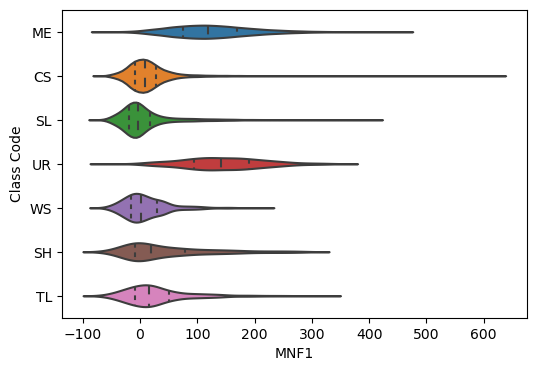

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


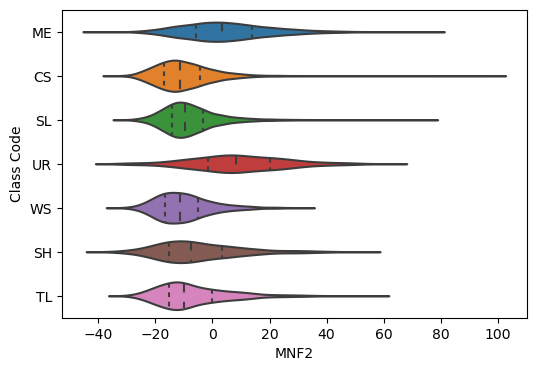

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

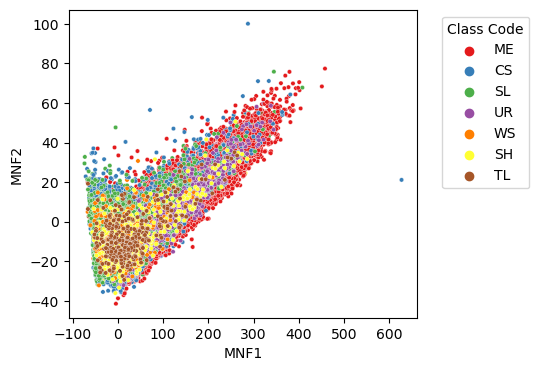

['ME' 'CS' 'SL' 'UR' 'WS' 'SH' 'TL']
[[ 14.95337918  -9.80524206]
 [124.87557649   4.92124453]
 [ 45.47368468  -5.01590765]
 [  8.03510632  -7.89044744]
 [ 29.45440111  -6.76093765]
 [144.44153149   9.18238566]
 [ 10.0718976   -9.91733039]]
[[  8.141241   -11.25185   ]
 [119.105485     3.4585713 ]
 [ 19.209367    -7.562219  ]
 [ -4.12617115  -9.501964  ]
 [ 15.6369915   -9.839984  ]
 [141.37572      8.210034  ]
 [  2.31631145 -11.221718  ]]


In [4]:
##################################
# Load the spectral library data #
##################################

# projdir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-urban-fuels/rooftop-materials'

# Read in the potential endmembers spatial data frame (MNF1,MNF2)
ref_sp = pd.read_csv("dc_data_reference_sampled_mnf.csv")
ref_sp = ref_sp[['class_code', 'uid', 'mnf1', 'mnf2']]
print(ref_sp.columns.values)

# Get the summary of each endmember class spectral response)
summary_stats = ref_sp.groupby('class_code')[['mnf1','mnf2']].describe()
print(summary_stats)

#########################################
# Plots and mean/median endmember array #
#########################################

# Create horizontal violin plot for MNF1
plt.figure(figsize=(6, 4))
sns.violinplot(x='mnf1', y='class_code', data=ref_sp, inner='quartile')
plt.xlabel('MNF1')
plt.ylabel('Class Code')
plt.show()

# Create horizontal violin plot for MNF2
plt.figure(figsize=(6, 4))
sns.violinplot(x='mnf2', y='class_code', data=ref_sp, inner='quartile')
plt.xlabel('MNF2')
plt.ylabel('Class Code')
plt.show()

# Create a scatter plot with MNF1 and MNF2, colored by class code
plt.figure(figsize=(4.5, 4))
sns.scatterplot(x='mnf1', y='mnf2', hue='class_code', data=ref_sp, palette='Set1', s=10)
plt.xlabel('MNF1')
plt.ylabel('MNF2')
plt.legend(title='Class Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Create an array of the class means
print(ref_sp['class_code'].unique())
# Create a mean and median MNF library np array by material type
means_by_class = ref_sp.groupby('class_code')[['mnf1', 'mnf2']].mean()
means_array = means_by_class.values  # Convert the means to a NumPy array
print(means_array)
# Median
med_by_class = ref_sp.groupby('class_code')[['mnf1', 'mnf2']].median()
med_array = med_by_class.values
print(med_array)

['Unnamed: 0' 'index' 'class_code' 'areaUTMsqft' 'uid' 'description'
 'coastal_blue' 'blue' 'green_i' 'green' 'yellow' 'red' 'rededge' 'nir'
 'ndre' 'vgnir' 'vrnir' 'ndbibg' 'ndbirg']
               mnf1                                                           \
              count        mean        std        min        25%         50%   
class_code                                                                     
CS          15431.0   32.376111  40.964429 -24.299030   8.679424   21.204987   
ME          26181.0  127.601089  67.841316 -15.686580  77.345180  120.782470   
SH            371.0   75.601176  73.762390 -19.340263  16.318737   53.713550   
SL           4445.0   43.481461  54.695144 -17.967400   7.213145   22.432020   
TL            403.0   52.253538  56.797370 -14.979664  14.435089   31.183643   
UR            912.0  145.291286  68.461459 -10.621248  95.322618  142.257895   
WS            443.0   34.805862  36.980728 -15.555125   9.236182   25.548447   

               

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


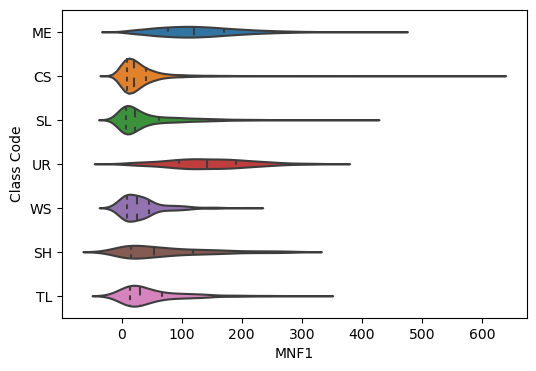

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


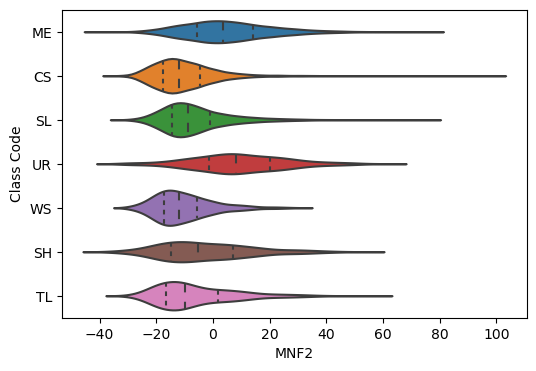

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

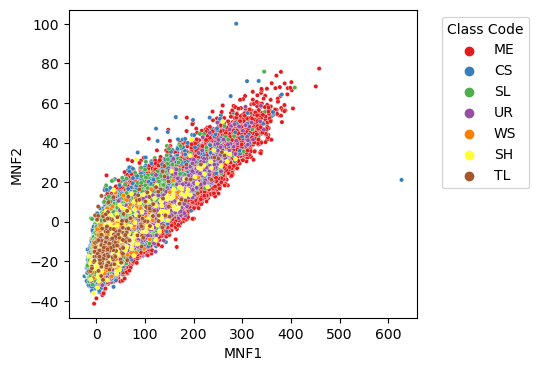

Mean Array:
['CS' 'ME' 'SH' 'SL' 'TL' 'UR' 'WS']
[[ 32.37611102 -10.13826076]
 [127.60108857   5.08399155]
 [ 75.60117587  -2.55049926]
 [ 43.4814606   -6.29427837]
 [ 52.25353769  -6.16634015]
 [145.29128569   9.22179697]
 [ 34.80586152 -10.29599016]]
Median Array:
['CS' 'ME' 'SH' 'SL' 'TL' 'UR' 'WS']
[[ 21.204987  -11.900926 ]
 [120.78247     3.6471124]
 [ 53.71355    -5.361388 ]
 [ 22.43202    -8.721015 ]
 [ 31.183643   -9.850783 ]
 [142.257895    8.2420615]
 [ 25.548447  -12.116794 ]]


In [6]:
"""
Remove sample points (centroids) which are likely tree canopy or vegetation
using the NDRE band from the PlanetScope imagery and a set of known reference locations of vegetation
threshold the sample points ot filter out any that are above the threshold (0.4)

Plot the distribution of training samples and a 2D projection by roof material
"""

# Bring in the full spectral library
ref_sp_f = pd.read_csv("dc_data_reference_sampled.csv")
print(ref_sp_f.columns.values)

# Attemp to create a threshold for vegetation
# Load vegetation samples (collected from the imagery)
veg = pd.read_csv("dc_data_veg_sampled.csv")
# Filter the training samples to remove possible vegetation cover, reclaulate the median array
ref_sp_f = ref_sp_f[ref_sp_f['ndre'] < 0.4]
ref_sp = ref_sp[ref_sp['uid'].isin(ref_sp_f['uid'])]  # retain non-vegetated samples from the original data
# Get the summary of each endmember class spectral response)
summary_stats = ref_sp.groupby('class_code')[['mnf1','mnf2']].describe()
print(summary_stats)

#########################################
# Plots and mean/median endmember array #
#########################################

# Create horizontal violin plot for MNF1
plt.figure(figsize=(6, 4))
sns.violinplot(x='mnf1', y='class_code', data=ref_sp, inner='quartile')
plt.xlabel('MNF1')
plt.ylabel('Class Code')
plt.show()

# Create horizontal violin plot for MNF2
plt.figure(figsize=(6, 4))
sns.violinplot(x='mnf2', y='class_code', data=ref_sp, inner='quartile')
plt.xlabel('MNF2')
plt.ylabel('Class Code')
plt.show()

# Create a scatter plot with MNF1 and MNF2, colored by class code
plt.figure(figsize=(4.5, 4))
sns.scatterplot(x='mnf1', y='mnf2', hue='class_code', data=ref_sp, palette='Set1', s=10)
plt.xlabel('MNF1')
plt.ylabel('MNF2')
plt.legend(title='Class Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Create an array of the class means/medians
# Create a mean and median np array
means_by_class = ref_sp.groupby('class_code')[['mnf1', 'mnf2']].mean().reset_index()
means_array = means_by_class[['mnf1','mnf2']].values  # Convert the means to a NumPy array
print("Mean Array:")
print(means_by_class['class_code'].unique())
print(means_array)
# Median
med_by_class = ref_sp.groupby('class_code')[['mnf1', 'mnf2']].median().reset_index()
med_array = med_by_class[['mnf1','mnf2']].values
print("Median Array:")
print(med_by_class['class_code'].unique())
print(med_array)

Shape: (2, 7555, 6046); 
NoData Value: None; 
Bands: <xarray.DataArray 'band' (band: 2)>
array([1, 2])
Coordinates:
  * band         (band) int64 1 2
    spatial_ref  int64 0; 
Band Names: ('mnf1', 'mnf2'); 
Data Type: float32


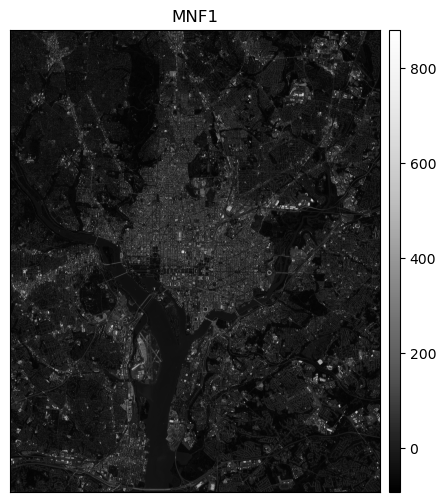

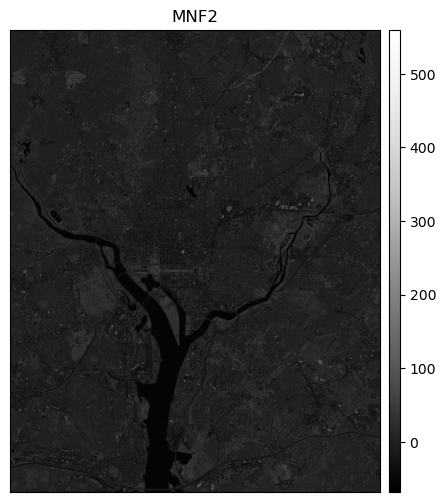

<Axes: title={'center': 'MNF2'}>

In [7]:
# Bring in the image file and get the projection information
mnf_path = "dc_data_psscene13b_mnf_.tif"
stack_mnf = rxr.open_rasterio(mnf_path)
print(
    f"Shape: {stack_mnf.shape}; \n"
    f"NoData Value: {stack_mnf.rio.nodata}; \n"
    f"Bands: {stack_mnf.band}; \n"
    f"Band Names: {stack_mnf.long_name}; \n"
    f"Data Type: {stack_mnf[0].dtype}")
# Plot one image as an example (green band)
ep.plot_bands(stack_mnf[0], title=["MNF1"], figsize=(6,6))
ep.plot_bands(stack_mnf[1], title=["MNF2"], figsize=(6,6))

<xarray.DataArray (band: 1, y: 7555, x: 6046)>
[45677530 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 3.163e+05 3.163e+05 ... 3.344e+05 3.344e+05
  * y            (y) float64 4.318e+06 4.318e+06 ... 4.296e+06 4.296e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_DATETIME:          2022:06:05 14:56:31
    TIFFTAG_IMAGEDESCRIPTION:  {"atmospheric_correction": {"aerosol_model": "...
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        0.75564974546432
    STATISTICS_MEAN:           0.41004499696248
    STATISTICS_MINIMUM:        -0.31730768084526
    STATISTICS_STDDEV:         0.19138691212421
    STATISTICS_VALID_PERCENT:  100
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ndre
count    43.000000
mean      0.605845
std       0.075303
min       0.425480
25%       0.555723
50%       0.624561
75%       0.667683
max       0.698196

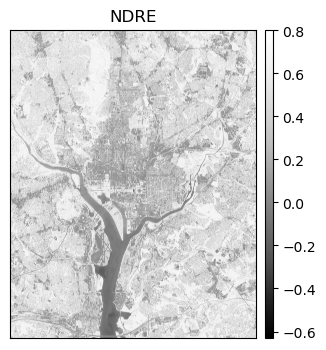

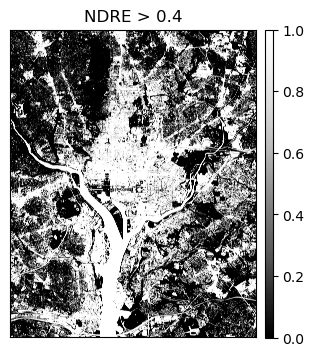

<Axes: title={'center': 'NDRE > 0.4'}>

In [11]:
#############################################################
# Create a binary vegetation mask using a threshold on NDRE #
#############################################################

ndre_path = os.path.join("dc_data_psscene13b_ndre.tif")
ndre = rxr.open_rasterio(stack_path)
print(ndre)

# Get the veg summary stats
print(veg['ndre'].describe())
# Plot the NDRE band
ep.plot_bands(ndre,figsize=(4,4),title=["NDRE"])
# Create a mask of vegetation where NDRE > 0.4 (based on the vegetation samples)
veg_mask = np.where(ndre > 0.4, 0, 1)
ep.plot_bands(veg_mask,figsize=(4,4),title=["NDRE > 0.4"])

(1, 7555, 6046)


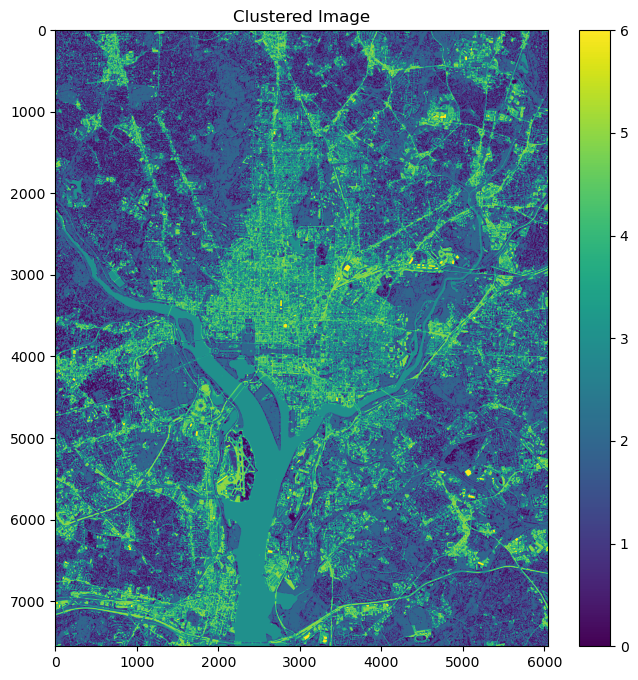

Time elapsed: 191.7 seconds.


In [14]:
############################################################
# Unsupervised classification of the MNF transformed image #
# To create a binary mask of water/veg & built-up          #
############################################################

import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from skimage import io

start_time = time.time()

# Load the image
image = io.imread(mnf_path)

# Reshape the image data into a 2D array, where each row is a pixel and each column is a band
# The -1 in the reshape function infers the number of rows based on the other dimensions.
# bands = image.reshape(-1, image.shape[2])
bands = image[:, :, [0, 1]].reshape(-1, 2)
# Optional: Standardize the features
scaler = StandardScaler()
bands_standardized = scaler.fit_transform(bands)
# Apply K-means clustering
n_clusters = 7  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
clusters = kmeans.fit_predict(bands_standardized)

# Reshape the cluster assignments to match the original image shape
clustered_image_ = clusters.reshape(1, image.shape[0], image.shape[1])
print(clustered_image_.shape)
# # Convert the array to a TIFF for export
# out_kmeans_path = os.path.join(projdir,'data/spatial/mod/dc_data/results/dc_data_kmeans5.tif')
# out_kmeans = array_to_tif(clustered_image_.T, stack_mnf, out_kmeans_path, clip=False, shp=None)

# Visualize the clustered image
plt.figure(figsize=(8, 8))
plt.imshow(clusters.reshape(image.shape[0], image.shape[1]))
plt.title('Clustered Image')
plt.colorbar()
plt.show()

print(f"Time elapsed: {round(time.time() - start_time, 1)} seconds.") 

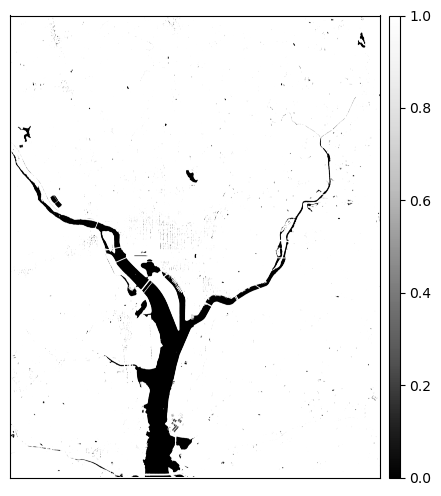

<Axes: >

In [15]:
# Cluster 3 is water/shade. Create a water/shade mask
water_mask = np.where(clustered_image_ == 3, 0, 1)
ep.plot_bands(water_mask, figsize=(6,6))

(2, 7555, 6046)


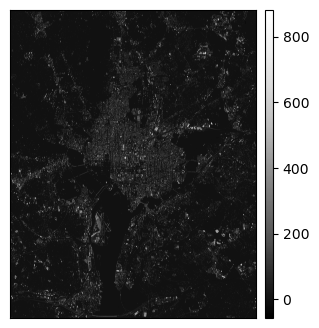

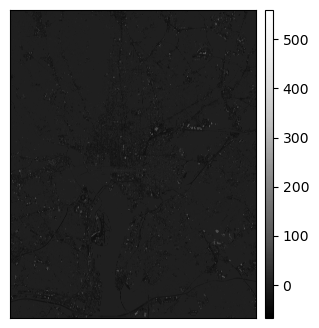

<class 'numpy.ndarray'>


In [22]:
# Mask the MNF data using the veg/water & built-up mask
stack_mnf_ = stack_mnf * veg_mask  # mask out vegetation pixels
stack_mnf_ = stack_mnf_ * water_mask  # mask out water/shade
print(stack_mnf_.shape)
ep.plot_bands(stack_mnf_[0],figsize=(4,4))
ep.plot_bands(stack_mnf_[1],figsize=(4,4))

In [18]:
# Grab projection information
# Get the WKT and GeoTransform
gdal.UseExceptions()  # Enable errors
try:
    ds = gdal.Open("dc_data_psscene13b_mnf_.tif")
    gt = ds.GetGeoTransform()
    wkt = ds.GetProjection()
except RuntimeError:  # <- Check first what exception is being thrown
    pass
del ds
print(f"GeoTransform: {gt}; \nWKT: {wkt}")

GeoTransform: (316269.0, 3.0, 0.0, 4318296.0, 0.0, -3.0); 
WKT: PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]


In [23]:
############################################
# Fully Constrained Least Squares Unmixing #
# Linear Spectral Mixture Analysis (LSMA)  #
# Single endmember per group               #
############################################

ems = med_array  # the median MNF values by roof material type
stack_mnf_arr = np.asarray(stack_mnf_)  # ensure that the MNF is a numpy array

import time
import traceback

num_processes = mp.cpu_count() - 1
print(f"Splitting across {num_processes} chunks for work ...")

# Check the data shapes
print(f"Image array (MNF) shape: {stack_mnf_arr.shape}; Endmember array shape: {ems.shape}")

# Split the MNF-transformed stack into chunks to be processed
chunks = np.array_split(stack_mnf_arr, num_processes, axis=2)

# Perform FCLS unmixing in parallel
start_time = time.time()
if __name__ == '__main__':
    
    # Function to parallelize FCLS unmixing
    def parallel_fcls_unmixing(chunk, endmembers):
        try:
            am = amap.FCLS()
            return am.map(chunk.T, endmembers, normalize=False)
        except Exception as e:
            traceback.print_exc()
            raise e
    
    with mp.Pool(processes=num_processes) as pool:
        try:
            unmix_results = pool.map(partial(parallel_fcls_unmixing, endmembers=ems), chunks)
            pool.close()
        except Exception as e:
            traceback.print_exc()
            raise e
        finally:
            pool.terminate()
            pool.join() 
            
print(f"Time elapsed: {round(time.time() - start_time, 1)/60} seconds.") 


Splitting across 31 chunks for work ...
Image array (MNF) shape: (2, 7555, 6046); Endmember array shape: (7, 2)
Time elapsed: 128.98 seconds.


In [27]:
# Retrieve the results
print(type(unmix_results))
print(len(unmix_results))
# Combine the FCLS results from all chunks back into a single array
ams_combined_parallel = np.concatenate(unmix_results)
print(f"Final combined array shape: {ams_combined_parallel.shape}")

<class 'list'>
31
Final combined array shape: (6046, 7555, 7)


In [29]:
print(gt, wkt)

(316269.0, 3.0, 0.0, 4318296.0, 0.0, -3.0) PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]


In [30]:
# Export the abundance ndarray as a multiband raster
import xarray as xr

print(f"Original shape: {stack_mnf_.shape}; \nAbundance maps shape: {ams_combined_parallel.shape}")
print(f"Length of 'y' attribute: {stack_mnf_.y}; \nLength of shape[1]: {ams_combined_parallel.shape[1]}")

# Transpose the new array before exporting
in_arr = ams_combined_parallel.transpose(2, 1, 0)
print(in_arr.shape)

# Assign the correct coordinates for the transposed 'y' dimension
band_coords = range(in_arr.shape[0])
y_coords = stack_mnf_.y.values
x_coords = stack_mnf_.x.values

# Store the new array and export
out_arr = xr.DataArray(
    in_arr,
    dims=("band", "y", "x"),
    coords={
        "band": band_coords,
        "y": y_coords,
        "x": x_coords,
    }
)

# Export the new DataArray as a new GeoTIFF file
# Assign projection information
out_arr.rio.set_crs(stack_mnf_.rio.crs)  # Set the CRS
out_arr.rio.write_transform(stack_mnf_.rio.transform())  # Set the GeoTransform
# out_arr = out_arr.rio.clip(dc.geometry)  # clip to DC county
output_path = "fcls_abundances_median.tif"
out_arr.rio.to_raster(output_path, compress='zstd', zstd_level=1,
                      dtype='float32', driver='GTiff')  # export to GeoTIFF
print("Success !! ...")

Original shape: (2, 7555, 6046); 
Abundance maps shape: (6046, 7555, 7)
Length of 'y' attribute: <xarray.DataArray 'y' (y: 7555)>
array([4318294.5, 4318291.5, 4318288.5, ..., 4295638.5, 4295635.5, 4295632.5])
Coordinates:
  * y            (y) float64 4.318e+06 4.318e+06 ... 4.296e+06 4.296e+06
    spatial_ref  int64 0; 
Length of shape[1]: 7555
(7, 7555, 6046)
Success !! ...


Class 0: CS
Class 1: ME
Class 2: SH
Class 3: SL
Class 4: TL
Class 5: UR
Class 6: WS


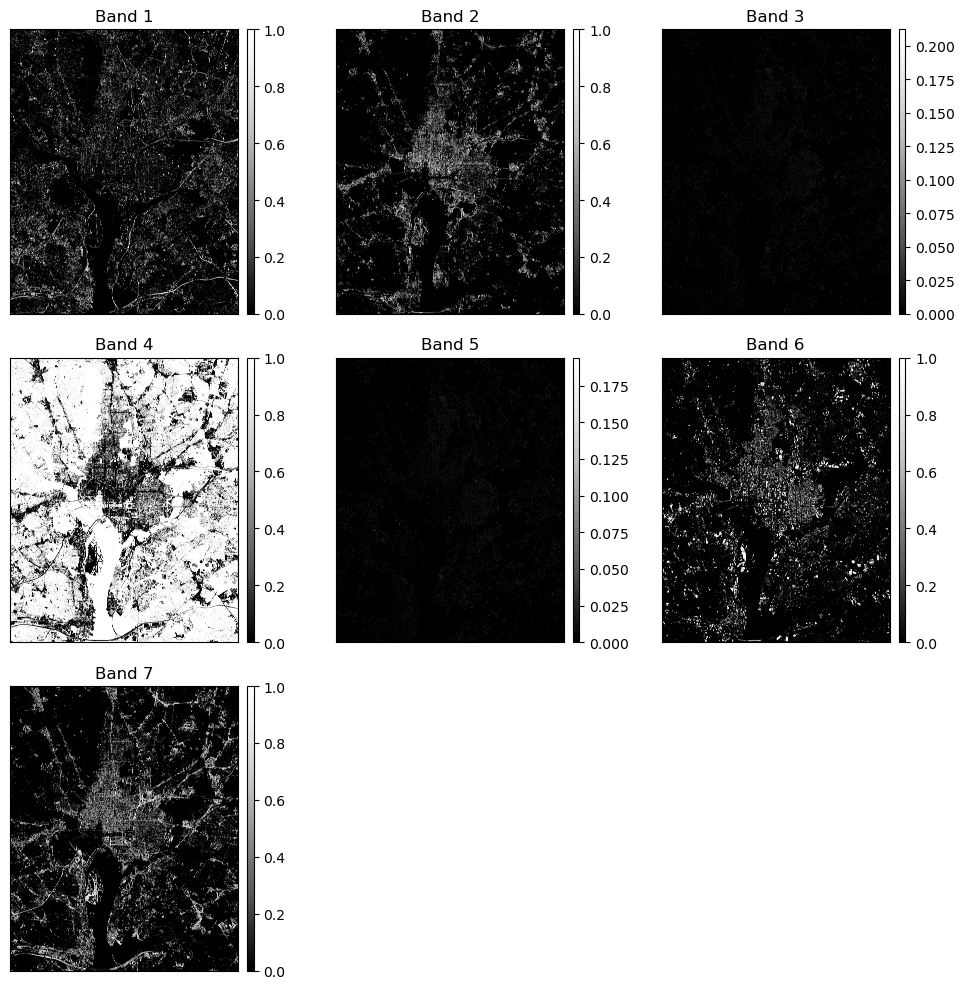

array([[<Axes: title={'center': 'Band 1'}>,
        <Axes: title={'center': 'Band 2'}>,
        <Axes: title={'center': 'Band 3'}>],
       [<Axes: title={'center': 'Band 4'}>,
        <Axes: title={'center': 'Band 5'}>,
        <Axes: title={'center': 'Band 6'}>],
       [<Axes: title={'center': 'Band 7'}>, <Axes: >, <Axes: >]],
      dtype=object)

In [32]:
# Test the output array by plotting the first abundance map
groups = med_by_class['class_code'].unique()
for i in range(len(groups)):
    print(f"Class {i}: {groups[i]}")
ep.plot_bands(
    ams_combined_parallel.T,
    scale=False,
    figsize=(10,10))